<a href="https://colab.research.google.com/github/thomasp05/GIF-7005-Projet/blob/features%2Ffcn-model/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pre-configuration

## Mount Google Drive

In [1]:
# Set up colab instance
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Clone and pull github repository

In [2]:
# Make sure clone at root
%cd /content

!pip3 install pydicom
!git clone https://github.com/thomasp05/gif-705-projet

import os
os.chdir('gif-705-projet')

# Add the local_modules directory to the set of paths
# Python uses to look for imports.
import sys
sys.path.append('/content/gif-705-projet')

/content
     |████████████████████████████████| 1.9MB 8.7MB/s 
Cloning into 'gif-705-projet'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 221 (delta 129), reused 125 (delta 58), pack-reused 0
Receiving objects: 100% (221/221), 1.41 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (129/129), done.


Checkout branch

In [8]:
!git checkout "features/fcn-model" #develop
!git pull

Already on 'features/fcn-model'
Your branch is up to date with 'origin/features/fcn-model'.
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 21 (delta 13), reused 10 (delta 8), pack-reused 0
Unpacking objects: 100% (21/21), done.
From https://github.com/thomasp05/gif-705-projet
   8ec6fcf..82a62c7  features/fcn-model -> origin/features/fcn-model
   dd417ee..51d515d  develop            -> origin/develop
Updating 8ec6fcf..82a62c7
Fast-forward
 models.py | 6 +++---
 1 file changed, 3 insertions(+), 3 deletions(-)


# Imports and load

In [9]:
import time

import torch


from dataset import *

from models import *
import models_parts
from train_helper import *

from torch.optim import lr_scheduler


torch.manual_seed(111)

## HYPERPARAMETERS

In [5]:
N_EPOCH = 3
start_epoch = 0
BATCH_SIZE = 4
google_drive_path = "/content/drive/My Drive/GIF-7005-Projet/"
checkpoint_path = google_drive_path + "checkpoint/" 

## Load dataset

In [6]:
dataset = dcm_dataset(google_drive_path + 'gif-7005-projet/data', transforms=Downsample())
print("Found {} images".format(len(dataset.img_files)))
dataset.subset()
dataset.subset()

train_set, test_set = train_test_split(dataset)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, num_workers=2)

dataloaders = {
  'train': train_loader,
  'val': test_loader
}

Found 26684 images


# UNet

Instantiate Model, optimizer and loss function

In [ ]:
model = UNet(n_channels=1, n_classes=1).to("cuda:0")

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)

## Load model checkpoint

In [ ]:
file_path = checkpoint_path + "unet_train.pt"
model, optim, start_epoch, best_loss = load_checkpoint(model, optim, file_path)
transfer_optimizer_parts(optim)

=> no checkpoint found at '/content/drive/My Drive/GIF-7005-Projet/checkpoint/unet_drive.pt'


## Simple Train

In [ ]:
# Test inference
timer = time.time()
for epoch in range(start_epoch, N_EPOCH):
  for img, (target, bounding_box) in train_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    loss = criterion(out, bounding_box)
    loss.backward()

    optim.step()

  print("Epoch : {}".format(epoch+1))
  print("Time  : {:.2f}".format(time.time()-timer))

Epoch : 1
Time  : 2864.73


In [ ]:
#checkpoint_path = google_drive_path + "unet_drive.pt"
#torch.save(model.state_dict(), checkpoint_path)

save_checkpoint(epoch, model, optim, loss, file_path)

In [ ]:
out_images = checkpoint_path + "out_images_after_train.pt"
torch.save(out, out_images)

### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

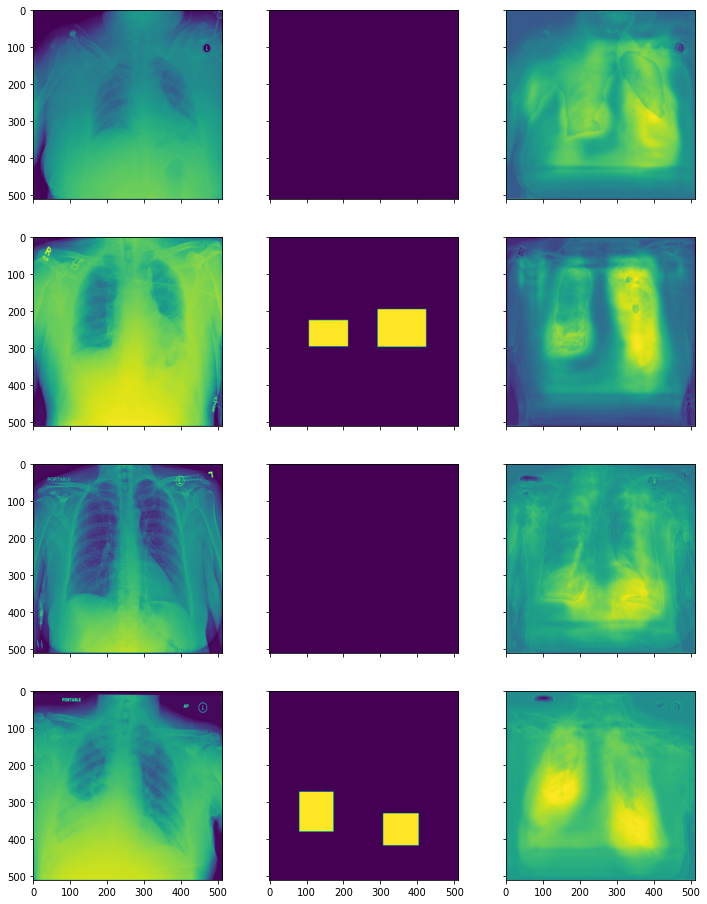

In [ ]:
plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()]) #


## Train

In [ ]:

#checkpoint_path = google_drive_path + "unet_train_8_epochs.pt"

model = train_model(model, optim, exp_lr_scheduler, dataloaders, N_EPOCH, file_path, best_loss)

Epoch 1/8
--------------------


KeyboardInterrupt: ignored

### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

In [ ]:
for img, (target, bounding_box) in test_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    break

plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()])


NEW TEST

In [ ]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, (_, labels)) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


# ResNet UNet

Instantiate Model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class=1).to(device)

optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Freeze backbone layers

In [ ]:
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False

## Load model checkpoint

In [ ]:
file_path = checkpoint_path + "resnet_unet.pt"
model, optim, start_epoch, best_loss = load_checkpoint(model, optim, file_path)
transfer_optimizer_parts(optim)

=> loading checkpoint '/content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt'
=> loaded checkpoint '/content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt' (epoch 1)


## Simple Train

In [ ]:
# Test inference

timer = time.time()
for epoch in range(N_EPOCH):
  for img, (target, bounding_box) in train_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    loss = criterion(out, bounding_box)
    loss.backward()

    optim.step()

  print("Epoch : {}".format(epoch+1))
  print("Time  : {:.2f}".format(time.time()-timer))

Epoch : 1
Time  : 1403.56


In [ ]:
#checkpoint_path = google_drive_path + "ResNetUNet_drive.pt"
#torch.save(model.state_dict(), checkpoint_path)

save_checkpoint(epoch, model, optim, loss, file_path)

In [ ]:
checkpoint_path = google_drive_path + "out_images_after_train_ResNetUNet.pt"
torch.save(out, checkpoint_path)

### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

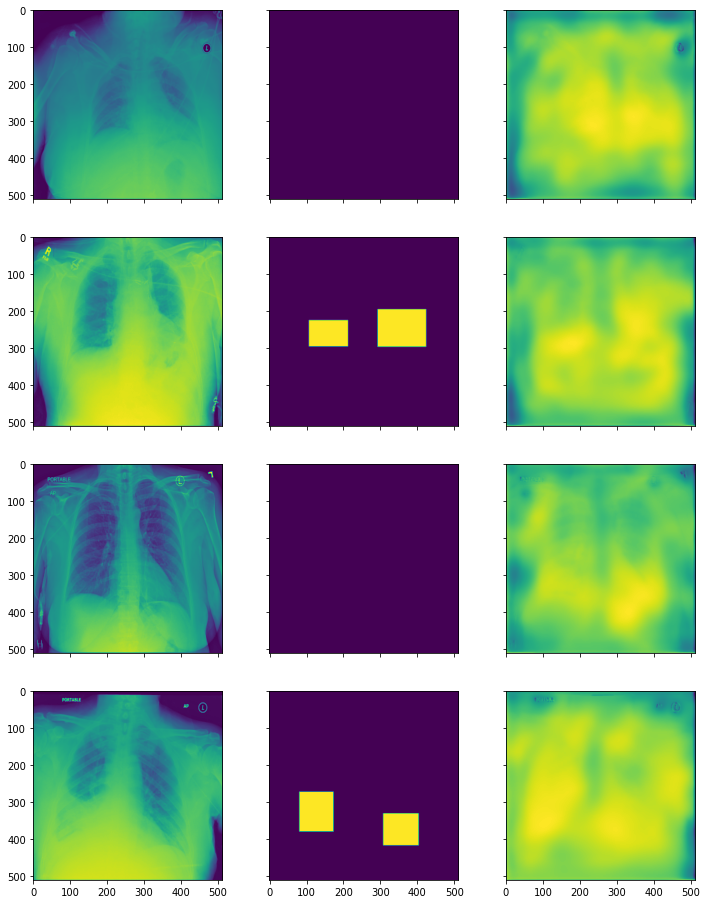

In [ ]:
plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()]) #


## Train

In [ ]:
model = train_model(model, optim, exp_lr_scheduler, dataloaders, N_EPOCH, file_path, best_loss)

Epoch 1/3
--------------------
train: bce: 0.252848, dice: 0.313608, loss: 0.283228
LR 0.0001
val: bce: 0.203834, dice: 0.315201, loss: 0.259518
saving best model to /content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt
25m 52s
Epoch 2/3
--------------------
train: bce: 0.248979, dice: 0.299840, loss: 0.274409
LR 0.0001
val: bce: 0.205662, dice: 0.306030, loss: 0.255846
saving best model to /content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt
25m 51s
Epoch 3/3
--------------------
train: bce: 0.236531, dice: 0.296620, loss: 0.266575
LR 0.0001
val: bce: 0.171937, dice: 0.339477, loss: 0.255707
saving best model to /content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt
25m 51s
Best val loss: 0.255707


### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

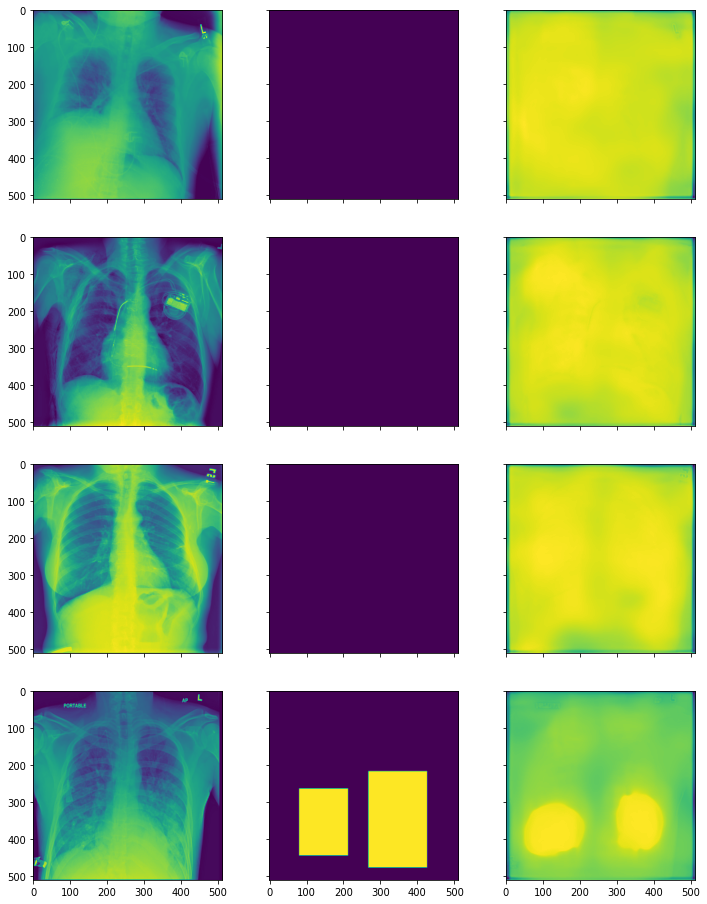

In [ ]:
for img, (target, bounding_box) in test_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    break

plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()])


# ResNet FCN

Instantiate Model

In [13]:

class FCN(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = torchvision.models.resnet18(pretrained=True)

        avg_weights = torch.mean(self.base_model.conv1.weight, 1, True)
        self.base_model.conv1 = nn.Conv2d(1, 64, 7, stride=2, padding=3, bias=False)
        self.base_model.conv1.weight = nn.Parameter(avg_weights)
        
        layers = list(self.base_model.children())
        self.layer1 = nn.Sequential(*layers[:5]) # size=(N, 64, x.H/2, x.W/2)
        self.upsample1 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.layer2 = layers[5]  # size=(N, 128, x.H/4, x.W/4)
        self.upsample2 = nn.Upsample(scale_factor=8, mode='bilinear')
        self.layer3 = layers[6]  # size=(N, 256, x.H/8, x.W/8)
        self.upsample3 = nn.Upsample(scale_factor=16, mode='bilinear')
        self.layer4 = layers[7]  # size=(N, 512, x.H/16, x.W/16)
        self.upsample4 = nn.Upsample(scale_factor=32, mode='bilinear')
        
        self.conv1k = nn.Conv2d(64 + 128 + 256 + 512, n_class, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer1(x)
        up1 = self.upsample1(x)
        x = self.layer2(x)
        up2 = self.upsample2(x)
        x = self.layer3(x)
        up3 = self.upsample3(x)
        x = self.layer4(x)
        up4 = self.upsample4(x)
        
        merge = torch.cat([up1, up2, up3, up4], dim=1)
        merge = self.conv1k(merge)
        out = self.sigmoid(merge)
        
        return out


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(n_class=1).to(device)

optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)

Freeze backbone layers

In [15]:
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False

ModuleAttributeError: ignored

## Load model checkpoint

In [16]:
file_path = checkpoint_path + "fcn.pt"
model, optim, start_epoch, best_loss = load_checkpoint(model, optim, file_path)
transfer_optimizer_parts(optim)

=> no checkpoint found at '/content/drive/My Drive/GIF-7005-Projet/checkpoint/fcn.pt'


## Simple Train

In [ ]:
# Test inference

timer = time.time()
for epoch in range(N_EPOCH):
  for img, (target, bounding_box) in train_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    loss = criterion(out, bounding_box)
    loss.backward()

    optim.step()

  print("Epoch : {}".format(epoch+1))
  print("Time  : {:.2f}".format(time.time()-timer))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
#checkpoint_path = google_drive_path + "ResNetUNet_drive.pt"
#torch.save(model.state_dict(), checkpoint_path)

save_checkpoint(epoch, model, optim, loss, file_path)

In [ ]:
checkpoint_path = google_drive_path + "out_images_after_train_FCN.pt"
torch.save(out, checkpoint_path)

### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

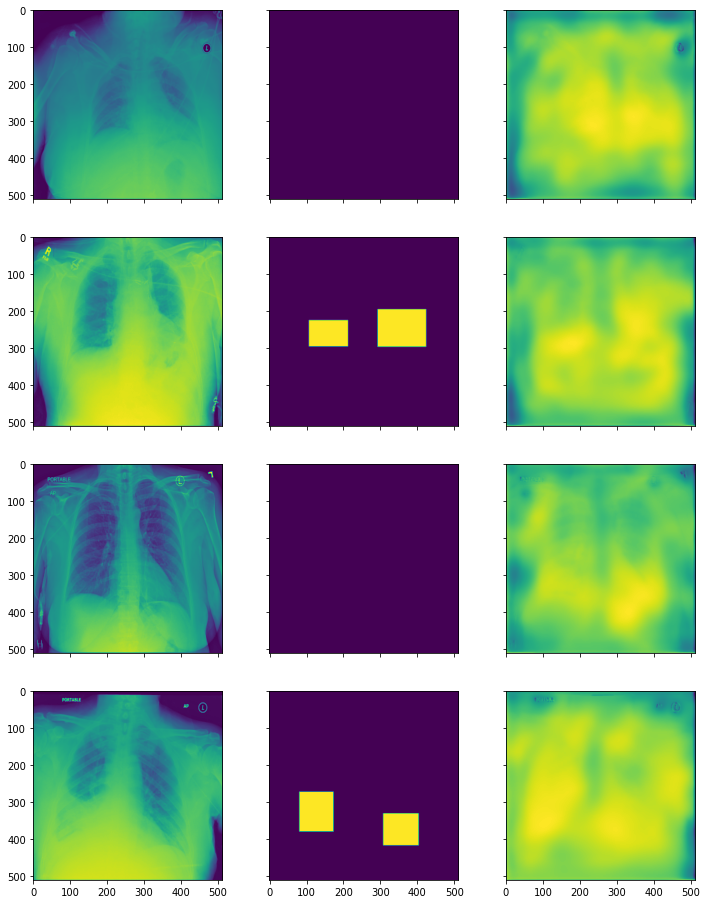

In [ ]:
plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()]) #


## Train

In [ ]:
model = train_model(model, optim, exp_lr_scheduler, dataloaders, N_EPOCH, file_path, best_loss)

Epoch 1/3
--------------------
train: bce: 0.252848, dice: 0.313608, loss: 0.283228
LR 0.0001
val: bce: 0.203834, dice: 0.315201, loss: 0.259518
saving best model to /content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt
25m 52s
Epoch 2/3
--------------------
train: bce: 0.248979, dice: 0.299840, loss: 0.274409
LR 0.0001
val: bce: 0.205662, dice: 0.306030, loss: 0.255846
saving best model to /content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt
25m 51s
Epoch 3/3
--------------------
train: bce: 0.236531, dice: 0.296620, loss: 0.266575
LR 0.0001
val: bce: 0.171937, dice: 0.339477, loss: 0.255707
saving best model to /content/drive/My Drive/GIF-7005-Projet/checkpoint/resnet_unet.pt
25m 51s
Best val loss: 0.255707


### Print images

Left: Input image, Middle: Correct mask, Rigth: Predicted mask

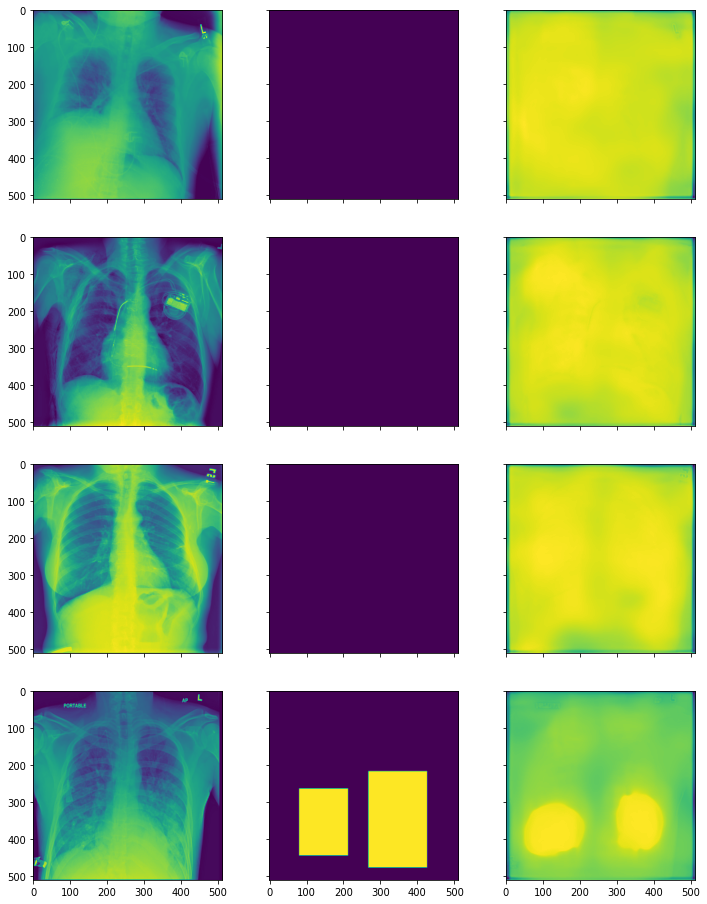

In [ ]:
for img, (target, bounding_box) in test_loader:
    
    optim.zero_grad()

    img = img.to("cuda:0")
    bounding_box = bounding_box.to("cuda:0")

    out = model(img)

    break

plot_side_by_side([img.cpu().squeeze(), bounding_box.cpu().squeeze().numpy(), out.detach().cpu().squeeze()])
